# Learning mixed policy

In [1]:
import torch
import confounding_robust_inference as cri

In [2]:
from matplotlib import pyplot as plt
plt.style.use("seaborn-whitegrid")
from matplotlib.cm import tab10

/tmp/ipykernel_2659232/966458967.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [3]:
# setup toy policy and data
_ = torch.random.manual_seed(0)
TORCH_DTYPE = cri.utils.types.get_default_torch_dtype()
beta1 = torch.randn((5,), dtype=TORCH_DTYPE)
beta2 = torch.randn((5,), dtype=TORCH_DTYPE)
beta3 = torch.randn((5,), dtype=TORCH_DTYPE)
policy1 = cri.policies.LogisticPolicy(beta1)
policy2 = cri.policies.LogisticPolicy(beta2)
policy3 = cri.policies.LogisticPolicy(beta3)
data = cri.data.SyntheticDataBinary()
Y, T, X, _, p_t, _ = data.sample(4000)

In [4]:
def plot_bound_tightness(base_policies):
    legend_targets = []
    policies_list = [[p] for p in base_policies] + [base_policies]
    for i, policies in enumerate(policies_list):

        i = 7 if i == len(base_policies) else i  # plot learned policy in grey
        
        def get_lower_bound_ci(Gamma):
            estimator = cri.estimators.DualKCMCPolicyLearner(const_type="Tan_box", Gamma=Gamma, D=30)
            estimator.fit(Y, T, X, p_t, policies)
            return estimator.predict_ci()
        
        def get_upper_bound_ci(Gamma):
            estimator = cri.estimators.DualKCMCPolicyLearner(const_type="Tan_box", Gamma=Gamma, D=30)
            estimator.fit(-Y, T, X, p_t, policies)
            low, high = estimator.predict_ci()
            return -high, -low
    
        Gammas = [1 + i / 10 for i in range(11)]
        lower_bound_cis = [get_lower_bound_ci(Gamma) for Gamma in Gammas]
        upper_bound_cis = [get_upper_bound_ci(Gamma) for Gamma in Gammas]
        
        lower_bounds = [(l + h) / 2 for (l, h) in lower_bound_cis]
        upper_bounds = [(l + h) / 2 for (l, h) in upper_bound_cis]
        lower_bound_cis_high = [h for (l, h) in lower_bound_cis]
        upper_bound_cis_high = [h for (l, h) in upper_bound_cis]
        lower_bound_cis_low = [l for (l, h) in lower_bound_cis]
        upper_bound_cis_low = [l for (l, h) in upper_bound_cis]
        
        lower_line = plt.plot(Gammas, lower_bounds, color=tab10(i), alpha=0.4)[0]
        upper_line = plt.plot(Gammas, upper_bounds, color=tab10(i), alpha=0.4)[0]
        lower_band = plt.fill_between(Gammas, lower_bound_cis_low, lower_bound_cis_high, color=tab10(i), alpha=0.1)
        upper_band = plt.fill_between(Gammas, upper_bound_cis_low, upper_bound_cis_high, color=tab10(i), alpha=0.1)
        legend_targets.append((lower_line, upper_line, lower_band, upper_band))
        
    plt.legend(legend_targets, [f"policy {i+1}" for i in range(len(base_policies))] + ["learned policy"])
    plt.xlabel(r"Sensitivity parameter $\Gamma$")
    plt.ylabel(r"Policy value")
    plt.savefig(f"fig/mixed_policy_learning.pdf")

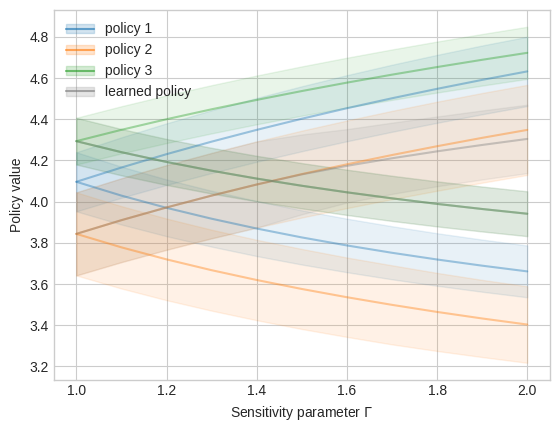

In [5]:
plot_bound_tightness([policy1, policy2, policy3])